<a href="https://colab.research.google.com/github/MohamedAfham/COVID-19-Cough-Detection/blob/master/Cough_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio
from librosa import display
import numpy as np
import scipy
import seaborn as sns
import random
import cv2 as cv
import math

import tensorflow as tf
import keras
from sklearn.metrics import confusion_matrix, classification_report
from keras import Sequential
from keras.layers import Dense, Dropout, Flatten,BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, Activation
from keras.models import load_model
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler

In [0]:
from google.colab import drive 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
def read_audio(audio_directory,audio_file):
  global sampling_rate
  audio,sampling_rate = librosa.load(audio_directory+audio_file)
  return (audio,sampling_rate)

def volume_aug(audio):
  factor_list = [0.5,1,1.5,2]
  factor = factor_list[np.random.randint(0,4)]
  augmented_samples = audio * factor
  return augmented_samples

def bg_noise_aug(audio,bg_noise):
  length = len(audio)
  rand_start = np.random.randint(0,len(bg_noise)- length)
  augmented_audio = audio + bg_noise[rand_start:rand_start + length]
  return augmented_audio

def melspectrogram(audio):  #no of mels means no of mel filters
    #samples, sampling_rate = librosa.core.load(directory + audio_file)   #loading data set
    samples = audio
    frame_size = 0.025
    frame_stride = frame_size * 0.7
    no_of_mels = 128
    frame_length, frame_step = frame_size * sampling_rate, frame_stride * sampling_rate  
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))
    samples_length = len(samples)
    num_frames = int(np.ceil(float(np.abs(samples_length - frame_length)) / frame_step))

    pad_samples_length = num_frames * frame_step + frame_length
    z = np.zeros((pad_samples_length - samples_length))
    pad_samples = np.append(samples, z)  #zero padding
       
    spect_samples = np.abs(librosa.stft(pad_samples, n_fft=frame_length, hop_length=frame_step, window=np.hamming(frame_length))) #calculating stft 
    spect_samples = librosa.amplitude_to_db(spect_samples, ref=np.max)
    mel_filter = librosa.filters.mel(sampling_rate, frame_length, n_mels=128, fmin=0, fmax=None)  #calculating mel filter array
    
    mel_spect_samples = np.dot(mel_filter, spect_samples)   #calculating mel spectrogram
    spectrum = mel_spect_samples.ravel().reshape(128,287,1)
    #spectrum = mel_spect_samples
    return spectrum

In [0]:
cough_audio = np.load('gdrive/My Drive/Cough Detection/Numpy Arrays/cough_audio.npy').tolist()
cough_audio = [np.array(xi) for xi in cough_audio]

station_audio = np.load('gdrive/My Drive/Cough Detection/Numpy Arrays/station_audio.npy').tolist()
station_audio = [np.array(xi) for xi in station_audio]

neighbor_audio = np.load('gdrive/My Drive/Cough Detection/Numpy Arrays/neighbor_audio.npy').tolist()
neighbor_audio = [np.array(xi) for xi in neighbor_audio]

metro_audio = np.load('gdrive/My Drive/Cough Detection/Numpy Arrays/metro_audio.npy').tolist()
metro_audio = [np.array(xi) for xi in metro_audio]

laugh_audio = np.load('gdrive/My Drive/Cough Detection/Numpy Arrays/laugh_audio.npy').tolist()
laugh_audio = [np.array(xi) for xi in laugh_audio]

hall_audio = np.load('gdrive/My Drive/Cough Detection/Numpy Arrays/hall_audio.npy').tolist()
hall_audio = [np.array(xi) for xi in hall_audio]

footstep_audio = np.load('gdrive/My Drive/Cough Detection/Numpy Arrays/footstep_audio.npy').tolist()
footstep_audio = [np.array(xi) for xi in footstep_audio]

airport_audio = np.load('gdrive/My Drive/Cough Detection/Numpy Arrays/airport_audio.npy').tolist()
airport_audio = [np.array(xi) for xi in airport_audio]

sneezing_audio = np.load('gdrive/My Drive/Cough Detection/Numpy Arrays/sneezing_audio.npy').tolist()
sneezing_audio = [np.array(xi) for xi in sneezing_audio]

snoring_audio = np.load('gdrive/My Drive/Cough Detection/Numpy Arrays/snoring_audio.npy').tolist()
snoring_audio = [np.array(xi) for xi in snoring_audio]

breathe_audio = np.load('gdrive/My Drive/Cough Detection/Numpy Arrays/breathe_audio.npy').tolist()
breathe_audio = [np.array(xi) for xi in breathe_audio]

crying_audio = np.load('gdrive/My Drive/Cough Detection/Numpy Arrays/crying_audio.npy').tolist()
crying_audio = [np.array(xi) for xi in crying_audio]

cough_audio_train = np.load('gdrive/My Drive/Cough Detection/Numpy Arrays/cough_audio_train.npy').tolist()
cough_audio_train = [np.array(xi) for xi in cough_audio_train]

In [0]:
non_cough_audio = station_audio + neighbor_audio + laugh_audio + hall_audio + footstep_audio + airport_audio + sneezing_audio + snoring_audio + crying_audio
test_non_cough_audio = breathe_audio + metro_audio

In [0]:
bg_noise_dir = ['Station.wav','NeighbourSpeaking.wav','Metro.wav','Hallway.wav','FootSteps.wav','AirportAnnouncements.wav']
audio_directory = 'gdrive/My Drive/Cough Detection/Sounds/Background Noise/'
bg_noise_list = []
for noise in range(len(bg_noise_dir)):
  audio_file = bg_noise_dir[noise]
  noise_add = read_audio(audio_directory,audio_file)[0]
  bg_noise_list.append(noise_add)


In [0]:
train_val_cough = []
test_cough = []

random.shuffle(cough_audio)
test_cough += cough_audio[:25]
train_val_cough += cough_audio[25:]

random.shuffle(cough_audio_train)
test_cough += cough_audio_train[:68]
train_val_cough += cough_audio_train[68:]

In [0]:
random.shuffle(train_val_cough)
train_cough,val_cough = train_val_cough[:int(len(train_val_cough)*0.8)], train_val_cough[int(len(train_val_cough)*0.8):]

random.shuffle(non_cough_audio)
train_non_cough,val_non_cough = non_cough_audio[:int(len(non_cough_audio)*0.8)], non_cough_audio[int(len(non_cough_audio)*0.8):]

train_files = [train_non_cough, train_cough]
val_files = [val_non_cough, val_cough]

**For the arrays with augmentation model.fit_generator() function**

In [0]:
def generator(batch_size, is_train):
  if is_train:
    audio = train_files
  else:
    audio = val_files

  while True:
    batch_features = np.zeros((batch_size,128,287,1))
    batch_labels = np.zeros((batch_size,1))
    rand_list = [[],[]]
    for n in range(batch_size):
      while True:
        label = np.random.randint(0,2)
        rand_num = random.randrange(len(audio[label]))
        if rand_num not in rand_list[label]:
          rand_list[label].append(rand_num)
          selected_audio = audio[label][rand_num]
          volume_aug_audio = volume_aug(selected_audio)
          rand_noise = random.randrange(len(bg_noise_list))
          bg_noise = bg_noise_list[rand_noise]
          bg_noise_added = bg_noise_aug(volume_aug_audio,bg_noise)
          spectrum = melspectrogram(bg_noise_added)
          batch_features[n] = spectrum
          batch_labels[n] = label
          break

    yield batch_features,batch_labels

#Callbacks
trained_model_path = 'gdrive/My Drive/Cough Detection/Pre trained Models/model-github.h5'
checkpoint = ModelCheckpoint(trained_model_path, 
                             monitor='val_accuracy', 
                             save_best_only=True, 
                             mode='max', 
                             period=1)

early_stop = EarlyStopping(monitor='val_accuracy', 
                           min_delta=0.001, 
                           patience=30, 
                           mode='max',
                           restore_best_weights=False)

def exp_decay(Epoch,learning_rate):
  decay = 0.1
  lrate = learning_rate * math.exp(-decay * Epoch)
  return lrate

lr_scheduler = LearningRateScheduler(exp_decay)

#Model 

shape = (128,287,1)
model = Sequential()

#Layer 1 
model.add(MaxPooling2D(pool_size=(2,2),input_shape=shape,name='MaxPooling2D_1'))
model.add(Conv2D(32, kernel_size=(5,5),padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(4,4)))

#Layer 2
model.add(Conv2D(64, kernel_size=(5,5),padding='same',name='Conv2D_2'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2,2),name='MaxPooling2D_3'))

model.add(Flatten(name = 'Flatten'))

#Layer 3
model.add(Dense(256,name = 'Dense_1'))
model.add(BatchNormalization(name = 'BatchNormalization_2'))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.5,name = 'Dropout_1'))

#Layer 4
model.add(Dense(128,name = 'Dense_2'))
model.add(BatchNormalization(name = 'BatchNormalization_3'))
model.add(LeakyReLU(alpha=0.1))
#model.add(Dropout(0.5,name = 'Dropout_2'))

#Layer 5
model.add(Dense(128,name = 'Dense_3'))
model.add(BatchNormalization(name = 'BatchNormalization_4'))
model.add(LeakyReLU(alpha=0.1))
#model.add(Dropout(0.5,name = 'Dropout_3'))

model.add(Dense(1,activation='sigmoid',name = 'Dense_4'))

adam = keras.optimizers.Adam(learning_rate = 1e-3, beta_1=0.9, beta_2=0.999, amsgrad=False)

model.compile(optimizer= adam, loss='binary_crossentropy', metrics=['accuracy'])
batch_size = 12
history = model.fit_generator(generator(batch_size,True), epochs=150,steps_per_epoch=50, validation_data=generator(batch_size,False),validation_steps=12,callbacks = [checkpoint,lr_scheduler,early_stop])

Epoch 1/150
50/50 [==============================] - 16s 328ms/step - loss: 0.4667 - accuracy: 0.7817 - val_loss: 1.2078 - val_accuracy: 0.4861
Epoch 2/150
50/50 [==============================] - 10s 193ms/step - loss: 0.3288 - accuracy: 0.8533 - val_loss: 1.5769 - val_accuracy: 0.4792
Epoch 3/150
50/50 [==============================] - 10s 204ms/step - loss: 0.2454 - accuracy: 0.9033 - val_loss: 5.6876 - val_accuracy: 0.5278
Epoch 4/150
50/50 [==============================] - 10s 199ms/step - loss: 0.2536 - accuracy: 0.9017 - val_loss: 1.3190 - val_accuracy: 0.4653
Epoch 5/150
50/50 [==============================] - 10s 203ms/step - loss: 0.1978 - accuracy: 0.9250 - val_loss: 4.2986 - val_accuracy: 0.4861
Epoch 6/150
50/50 [==============================] - 10s 204ms/step - loss: 0.2055 - accuracy: 0.9233 - val_loss: 4.1239 - val_accuracy: 0.4861
Epoch 7/150
50/50 [==============================] - 10s 201ms/step - loss: 0.1627 - accuracy: 0.9367 - val_loss: 3.2792 - val_accuracy:

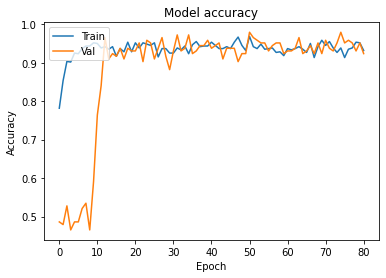

In [0]:
fig ,ax = plt.subplots()
ax.plot(history.history['accuracy'])
ax.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

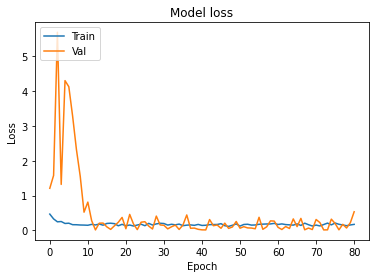

In [0]:
fig ,ax = plt.subplots()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [0]:
#Prepare the test data
random.shuffle(test_non_cough_audio)
test_non_cough = test_non_cough_audio

random.shuffle(test_cough)

test_data= [test_non_cough,test_cough]

In [0]:
test_model = load_model('gdrive/My Drive/Cough Detection/Pre trained Models/model-github.h5')

n_input = len(test_data[1]) + len(test_data[0])
model_data = np.zeros((n_input,128,287,1))
model_label = np.zeros((n_input,1))
data_list = [[],[]]

for i in range(n_input):
  while True:
    label = np.random.randint(0,2)
    rand_num = random.randrange(len(test_data[label]))
    if rand_num not in data_list[label]:
      data_list[label].append(rand_num)
      selected_audio = test_data[label][rand_num]
      volume_aug_audio = volume_aug(selected_audio)
      rand_noise = random.randrange(len(bg_noise_list))
      bg_noise = bg_noise_list[rand_noise]
      bg_noise_added = bg_noise_aug(volume_aug_audio,bg_noise)
      spectrum = melspectrogram(bg_noise_added)
      model_data[i] = spectrum
      model_label[i] = label
      break


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

pred = model.predict(x = model_data,batch_size = n_input)
print (model.evaluate(x = model_data, y = model_label,batch_size=n_input))
preds = np.array([int(np.round(pred[i])) for i in range(len(pred))])

print (confusion_matrix(model_label,preds))
print ('\n')
print (classification_report(model_label,preds))

186/186 [==============================] - 0s 805us/step
[0.19727760553359985, 0.9247311949729919]
[[93  0]
 [14 79]]


              precision    recall  f1-score   support

         0.0       0.87      1.00      0.93        93
         1.0       1.00      0.85      0.92        93

    accuracy                           0.92       186
   macro avg       0.93      0.92      0.92       186
weighted avg       0.93      0.92      0.92       186

